# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

In [225]:
import pandas as pd
import numpy as np

# Read data set
data = pd.read_csv('Task 1.csv')
print(data.shape)
data.head()

(1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [226]:
# Check count of distinct values in columns gender, lunch
gender_col = data['gender'].unique()
print(data['gender'].nunique(), gender_col)

lunch_col = data['lunch'].unique()
print(data['lunch'].nunique(), lunch_col)

course_col = data['test preparation course'].unique()
print(data['test preparation course'].nunique(), course_col)

race_col = data['race/ethnicity'].unique()
race_col.sort()
print(data['race/ethnicity'].nunique(), race_col)

level_col = data['parental level of education'].unique()
print(data['parental level of education'].nunique(), level_col)

# Array of orginized parental level of education
level_col = ['some high school', 'high school', 'some college', 'associate\'s degree', 'bachelor\'s degree', 'master\'s degree']

print('\nOrginized parental level of education: ', level_col)

2 ['male' 'female']
2 ['standard' 'free/reduced']
2 ['completed' 'none']
5 ['group A' 'group B' 'group C' 'group D' 'group E']
6 ['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]

Orginized parental level of education:  ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]


In [227]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Create encoder
ordinalEncoder = OrdinalEncoder(categories=[race_col, level_col])
oneHotEncoder = OneHotEncoder()

ordinal_features = ['race/ethnicity', 'parental level of education']
one_hot_features = ['gender', 'lunch', 'test preparation course']

In [228]:
# Encode ordinal features
new_oe_features = ordinalEncoder.fit_transform(data[ordinal_features])
new_oe_cols = pd.DataFrame(new_oe_features, dtype=int, columns=ordinal_features)

In [229]:
# Encode one hot features
new_ohe_features = oneHotEncoder.fit_transform(data[one_hot_features])
new_ohe_cols = pd.DataFrame(new_ohe_features.toarray(), dtype=int, columns=oneHotEncoder.get_feature_names(one_hot_features))

C:\Users\Dale\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [230]:
# Combine all features
new_data = pd.concat([data], axis=1)
new_data = new_data.drop(columns=ordinal_features + one_hot_features )
new_data = pd.concat([new_data, new_oe_cols, new_ohe_cols], axis=1)
new_data.head()

,math score,reading score,writing score,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,67,67,63,0,1,0,1,0,1,1,0
1,40,59,55,3,0,1,0,1,0,0,1
2,59,60,50,4,2,0,1,1,0,0,1
3,77,78,68,1,1,0,1,0,1,0,1
4,78,73,68,4,3,0,1,0,1,1,0


In [231]:
from sklearn.model_selection import train_test_split

# Split data to target and features
X = new_data.iloc[:, 3:].values
y = new_data.iloc[:, :3].values

# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [232]:
from sklearn.preprocessing import StandardScaler

# Scale testing and training data
scaler = StandardScaler()
scaler.fit(X_train)

# Create Data Frames with scaled data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [233]:
# # Scale target data
# target_scaler = StandardScaler()
# target_scaler.fit(y_train)

# # Create Data Frames with scaled data
# y_train = target_scaler.transform(y_train)
# y_test = target_scaler.transform(y_test)

In [234]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [235]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

In [236]:
data, label = next(iter(train_dataloader))
label.shape

torch.Size([32, 3])

In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom neural network class
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.hidden1 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 3)

    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))
        x = self.output(x)
        return x

# Create neural network
use_cuda = torch.cuda.is_available()
print("cuda" if use_cuda else "cpu")
device = torch.device("cuda" if use_cuda else "cpu")
model = ANN().to(device)

print(model)

cuda
ANN(
  (hidden1): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)


In [238]:
epochs = 100
lr = 0.001
momentum = 0.9
seed = 1
log_interval = 4

loss_fn = nn.MSELoss(reduction='mean')

In [239]:
# Function to compare first element in batch with the first target value 
def print_batch_element_error(batch, target):
    # get value from tensor
    batch = batch.cpu().data.numpy()
    target = target.cpu().data.numpy()
    predicted_v = batch[0]
    target_v = target[0]
    # predicted_v = target_scaler.inverse_transform(batch)
    # predicted_v = predicted_v[0]
    # target_v = target_scaler.inverse_transform(target)
    # target_v = target_v[0]
    error = np.abs(predicted_v - target_v)
    print('Predicted: ', predicted_v, 'Target: ', target_v, 'Error: ', error, '\n')


def get_accuracy(output, target, threshold=2):
    output = output.cpu().data.numpy()
    target = target.cpu().data.numpy()
    # output = target_scaler.inverse_transform(output)
    # target = target_scaler.inverse_transform(target)
    accuracy = 0
    for i in range(len(output)):
        predicted_v = output[i]
        target_v = target[i]
        error = np.abs(predicted_v - target_v)
        for j in range(len(error)):
            if error[j] <= threshold:
                error[j] = 1
            else:
                error[j] = 0
        accuracy += np.sum(error)/3
    
    return accuracy/len(output)

In [240]:
import operator

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf

        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric):
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

In [241]:
def train(model, device, train_loader, optimizer, epoch, loss_func, accuracy_func, acc_treshold = 2, task = 1):
    model.train()
    epoch_loss = 0
    accuracy = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data).squeeze()
        # print('Output: ', output)
        # print('Target: ', target)
        # print(output.shape)
        # print(target.shape)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        curr_accuracy = accuracy_func(output, target, acc_treshold)
        accuracy += curr_accuracy
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.4f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item(), curr_accuracy))

    # Print average scores for epoch
    epoch_loss /= len(train_loader.dataset)

    print('\nTrain Epoch: Average Loss:', 
          epoch_loss,
          '\tAverage Accuracy:', 
          accuracy / len(train_loader))

In [242]:
def test(model, device, test_loader, loss_func, accuracy_func, acc_treshold = 2):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            test_loss += loss_func(output, target).item()
            accuracy += accuracy_func(output, target, acc_treshold)

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f} Average accuracy: {:.4f}\n'.format(
        test_loss, accuracy / len(test_loader)))

    return test_loss

In [243]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(model, device, train_dataloader, optimizer, epoch, loss_fn, get_accuracy, 2)
    test_loss = test(model, device, test_dataloader, loss_fn, get_accuracy, 2)

    if early_stopping(test_loss):
        break

Train Epoch: 1 [0/800 (0%)]	Loss: 5620.923828	Accuracy: 0.0000
Train Epoch: 1 [128/800 (16%)]	Loss: 4790.321289	Accuracy: 0.0000
Train Epoch: 1 [256/800 (32%)]	Loss: 4374.432129	Accuracy: 0.0000
Train Epoch: 1 [384/800 (48%)]	Loss: 3388.329590	Accuracy: 0.0000
Train Epoch: 1 [512/800 (64%)]	Loss: 2821.800781	Accuracy: 0.0000
Train Epoch: 1 [640/800 (80%)]	Loss: 1672.812012	Accuracy: 0.0000
Train Epoch: 1 [768/800 (96%)]	Loss: 1031.232178	Accuracy: 0.0208

Train Epoch: Average Loss: 108.97855682373047 	Average Accuracy: 0.00875

Test set: Average loss: 14.3505 Average accuracy: 0.0789

Train Epoch: 2 [0/800 (0%)]	Loss: 303.515320	Accuracy: 0.1562
Train Epoch: 2 [128/800 (16%)]	Loss: 854.392944	Accuracy: 0.0104
Train Epoch: 2 [256/800 (32%)]	Loss: 415.416687	Accuracy: 0.0833
Train Epoch: 2 [384/800 (48%)]	Loss: 248.516037	Accuracy: 0.0833
Train Epoch: 2 [512/800 (64%)]	Loss: 320.132416	Accuracy: 0.0937
Train Epoch: 2 [640/800 (80%)]	Loss: 168.443954	Accuracy: 0.1354
Train Epoch: 2 [768/8

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

In [244]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

test_path = './triple_mnist/triple_mnist/test/'
train_path = './triple_mnist/triple_mnist/train/'
val_path = './triple_mnist/triple_mnist/val/'

batch_size = 64

transform = transforms.Compose([
    transforms.Resize(84),
    transforms.ToTensor()
])

train_data = ImageFolder(root=train_path, transform=transform)

test_data = ImageFolder(root=test_path, transform=transform)

val_data = ImageFolder(root=val_path, transform=transform)

In [245]:
def fix_data_targets(data):
    classes = data.classes
    for i in range(len(data.samples)):
        path, index = data.samples[i]
        cl = classes[index]
        arr = np.zeros((3,), dtype=np.int64)
        for j in range(len(cl)):
            arr[j] = int(cl[j])
        new_sample = (path, arr)
        data.samples[i] = new_sample
        data.targets[i] = arr

In [246]:
fix_data_targets(train_data)
fix_data_targets(test_data)
fix_data_targets(val_data)

In [247]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False) 
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

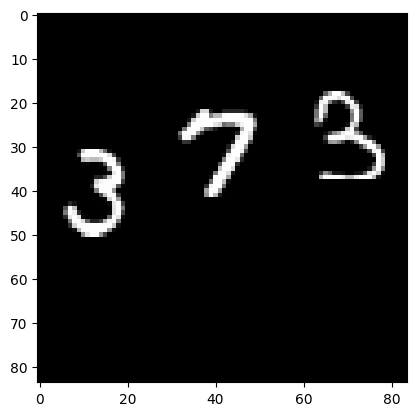

In [248]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))
plt.imshow(np.transpose(images[0].cpu().detach().numpy(), (1, 2, 0)))

In [249]:
class ANN_Task2(ANN):
    def __init__(self):
        super(ANN_Task2, self).__init__()
        self.hidden1 = nn.Linear(84*84*3, 2500)
        self.output = nn.Linear(2500, 30)
        
    def forward(self, x):
        x = x.view(-1, 84*84*3)
        x = F.leaky_relu(self.hidden1(x))
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        x = x.view(-1, 3, 10)
        x = x.transpose(1, 2)
        return x

In [250]:
# device = torch.device("cuda" if use_cuda else "cpu")
model = ANN_Task2().to(device)

print(model)

ANN_Task2(
  (hidden1): Linear(in_features=21168, out_features=2500, bias=True)
  (output): Linear(in_features=2500, out_features=30, bias=True)
)


In [251]:
epochs = 1
lr = 0.01
momentum = 0.5
log_interval = 10

loss_fn = nn.NLLLoss()

In [252]:
def nll_loss(output, target, reduce=True):
    out_sum = 0
    for i in range(len(target)):
        out_sum += output[i][target[i]]
    return -(out_sum.sum()/len(target) if reduce else out_sum)

In [253]:
from torch.autograd import Variable

def task2_loss_function(output, target):
    if output.shape[0] == batch_size:
        output = output.cpu().data.numpy()
        target = target.cpu().data.numpy()

        for i in range(len(output)):
            # print(output[i], target[i])
            num1 = output[i][0:10]
            num2 = output[i][10:20]
            num3 = output[i][20:30]

            # print('pred:', num1.argmax(), num2.argmax(), num3.argmax())
            # print('true:', target[i][0], target[i][1], target[i][2])

            loss = nll_loss([num1, num2, num3], target[i])

            # print(loss)
            return Variable(torch.tensor(loss), requires_grad=True)
            # num1 = num1.argmax()
            # num2 = num2.argmax()
            # num3 = num3.argmax()

            # print(num1, num2, num3)
    
    # print(num1, num2, num3)

In [254]:
def task2_accuracy(output, target, treshold):
    return 1

In [255]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, loss_fn, task2_accuracy, 1, 2)
    test_loss = test(model, device, test_loader, loss_fn, task2_accuracy, 1)

    if early_stopping(test_loss):
        break

Train Epoch: 1 [0/64000 (0%)]	Loss: 3.404877	Accuracy: 1.0000
Train Epoch: 1 [640/64000 (1%)]	Loss: 3.395308	Accuracy: 1.0000
Train Epoch: 1 [1280/64000 (2%)]	Loss: 3.398809	Accuracy: 1.0000
Train Epoch: 1 [1920/64000 (3%)]	Loss: 3.396696	Accuracy: 1.0000
Train Epoch: 1 [2560/64000 (4%)]	Loss: 3.391877	Accuracy: 1.0000
Train Epoch: 1 [3200/64000 (5%)]	Loss: 3.391459	Accuracy: 1.0000
Train Epoch: 1 [3840/64000 (6%)]	Loss: 3.387333	Accuracy: 1.0000
Train Epoch: 1 [4480/64000 (7%)]	Loss: 3.384262	Accuracy: 1.0000
Train Epoch: 1 [5120/64000 (8%)]	Loss: 3.387422	Accuracy: 1.0000
Train Epoch: 1 [5760/64000 (9%)]	Loss: 3.380862	Accuracy: 1.0000
Train Epoch: 1 [6400/64000 (10%)]	Loss: 3.375652	Accuracy: 1.0000
Train Epoch: 1 [7040/64000 (11%)]	Loss: 3.379961	Accuracy: 1.0000
Train Epoch: 1 [7680/64000 (12%)]	Loss: 3.370127	Accuracy: 1.0000
Train Epoch: 1 [8320/64000 (13%)]	Loss: 3.364249	Accuracy: 1.0000
Train Epoch: 1 [8960/64000 (14%)]	Loss: 3.365153	Accuracy: 1.0000
Train Epoch: 1 [9600/640

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. What data augmentation techniques did you use?
    - *Answer*
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [256]:
# TODO: Implement task 3

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [257]:
# TODO: Implement task 4

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*